# 1D modified Korteweg-De Vries equation on a periodic domain

The [modified Korteweg-De Vries equation](https://en.wikipedia.org/wiki/Korteweg%E2%80%93De_Vries_equation) is a Partial Differential Equation (PDE) that describes the non-linear propagation of waves. It can model solitons and the interaction between solitions can lead to amplification, known as rogue waves.
we start with the equation in the following form:

$\frac{\partial u}{\partial t}+6*u^2 \frac{\partial u}{\partial x}+ \frac{\partial^3 u}{\partial x^3}=0$

on the domain $x \in [0, L]$ and $0 \le t \le T$. The domain is considered periodic in $x$. 

For the initial condition we will use a combination of solitons of the form:

$u(x,t=0) = a/\cosh(a(x-x_0-a^2t))$ 

For numerical discretization we follow a note by [Raslan](http://emis.muni.cz/journals/GMN/yahoo_site_admin/assets/docs/9_GMN-7112-V27N1.149222830.pdf)


In [1]:
# goto folder of this notebook (If you move this notebook then also copy the Project.toml file and run instantiate to install the packages)
cd(@__DIR__)
# load the environment
using Pkg 
Pkg.activate(".")  # activate the environment for this notebook
# load the packages
using OrdinaryDiffEq
using ComponentArrays
using Plots
using JLD2


  Activating project at `~/dellete/src/julia_ml_tests.jl.git/model_1d`


In [2]:
# define the model

"""
    Modified Korteweg-De Vries Periodic

    A 1D mKdV equation with periodic boundary conditions.
    The state is represented vector:
    - u: velocity
"""
struct mkdv_equation
    Δx::Float64 # grid spacing
    du_dx::Vector{Float64} # temporary storage for du/dx
    d2u_dx2::Vector{Float64} # temporary storage for d2u/dx2
    d3u_dx3::Vector{Float64} # temporary storage for d3u/dx3
end

function dx!(du,u,Δx) #central du_dx for 6u^2*du/dx term
    n=length(u)
    for i=2:n-1
        du[i]=(u[i+1]-u[i-1])/(2*Δx)
    end
    #left periodic boundary condition
    du[1]=(u[2]-u[end])/(2*Δx)
    # right periodic boundary condition
    du[end]=(u[1]-u[end-1])/(2*Δx)
end

function dx2!(du,u,Δx) #central d2u_dx2 
    n=length(u)
    for i=2:n-1
        du[i]=(u[i+1]-2*u[i]+u[i-1])/(Δx*Δx)
    end
    #left periodic boundary condition
    i=1
    du[1]=(u[i+1]-2*u[i]+u[end])/(Δx*Δx)
    # right periodic boundary condition
    i=n
    du[end]=(u[1]-2*u[i]+u[i-1])/(Δx*Δx)
end

function dx3!(du,u,Δx) #central third difference for d3u/dx3 term
    n=length(u)
    for i=3:n-2
        du[i]=(-u[i-2]+2*u[i-1]-2*u[i+1]+u[i+2])/(2*Δx^3)
    end
    # at n=1
    du[1]=(-u[end-1]+2*u[end]-2*u[2]+u[3])/(2*Δx^3)
    # at n=2
    du[2]=(-u[end]+2*u[1]-2*u[3]+u[4])/(2*Δx^3)
    # at n=end-1
    du[end-1]=(-u[end-3]+2*u[end-2]-2*u[end]+u[1])/(2*Δx^3)
    # at n=end
    du[end]=(-u[end-2]+2*u[end-1]-2*u[1]+u[2])/(2*Δx^3)
end


"""
# Define the function that computes the time derivative of the state
 du/dt = -6u^2 * du/dx - * d3u/dx3
 for the mKdV equation
"""
function (f::mkdv_equation)(du_dt, u, p, t)
    Δx=f.Δx
    du_dx=f.du_dx #link to cache
    dx!(du_dx,u,Δx) # compute du/dx
    d2u_dx2=f.d2u_dx2 #link to cache
    dx2!(d2u_dx2,u,Δx) # compute d2u/dx2
    d3u_dx3=f.d3u_dx3 #link to cache
    dx3!(d3u_dx3,u,Δx) # compute d3u/dx3
    @. du_dt = -6u^2*du_dx - d3u_dx3 + 0.01*d2u_dx2 # add a bit of diffusion to stabilize the solver
end

function mkdv_initial_condition(x,a::AbstractVector,x0::AbstractVector)
    result = zeros(length(x))
    for i in eachindex(a)
        result .+= a[i] .* sech.(a[i] .* (x .- x0[i]))
    end
    return result
end





mkdv_initial_condition (generic function with 1 method)

In [14]:
# setting up the problem

# parameters
nx=500     # number of spatial points
L=50.0     # length of the domain
Δx=L/nx    # spatial step
a=[1.0,-0.8]    # amplitude of the initial condition
x0=[L/4,L/2]   # initial position of the wave
p=()       # parameters (not used in this case)

# spatial grid
x=Δx*(1:nx) # spatial grid points

# initial condition
u0 = mkdv_initial_condition(x,a,x0)
#u0[100]+=0.25 # perturb initial condition to test the stability of the solver --> seems to be working

# initialize model struct
f=mkdv_equation(Δx, similar(u0), similar(u0), similar(u0))

# time span
t_end=30.0


30.0

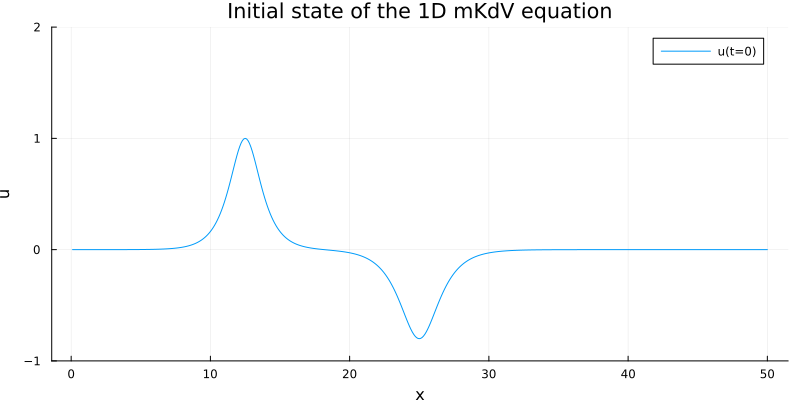

In [15]:
# plot the initial state
p1=plot(x, u0, label="u(t=0)", xlabel="x", ylabel="u")
plot(p1, size=(800,400), title="Initial state of the 1D mKdV equation",ylim=(-1, 2))

In [ ]:
#u0[100]+=0.25
#t_end=0.01
prob = ODEProblem(f, u0, (0.0, t_end))
#@time sol = solve(prob,RK4(),saveat=0.1,adaptive=false,dt=1e-3) # run with relatively large fixed time step
@time sol = solve(prob,RK4(),saveat=0.1) #adaptive time step

nothing

  0.176471 seconds (988 allocations: 1.250 MiB)


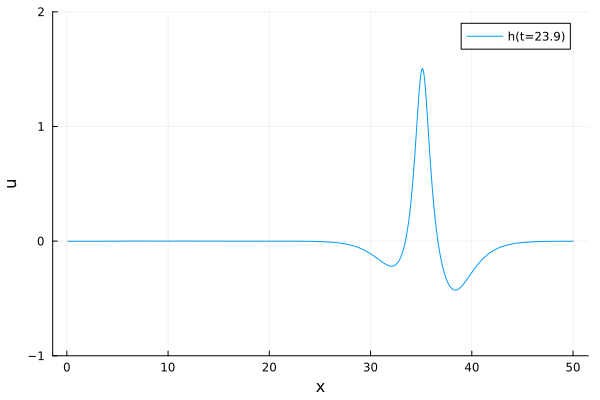

In [17]:
# plot a t peak amplification
i=240
plot(x,sol[i], label="h(t=$(round(sol.t[i],digits=2)))", xlabel="x", ylabel="u", ylim=(-1, 2))


  6.138967 seconds (4.91 M allocations: 183.373 MiB, 0.46% gc time)


┌ Info: Saved animation to /home/verlaan/dellete/src/julia_ml_tests.jl.git/model_1d/mkdv1d_periodic.gif
└ @ Plots /home/verlaan/.julia/packages/Plots/uiCPf/src/animation.jl:156


Plots.AnimatedGif("/home/verlaan/dellete/src/julia_ml_tests.jl.git/model_1d/mkdv1d_periodic.gif")
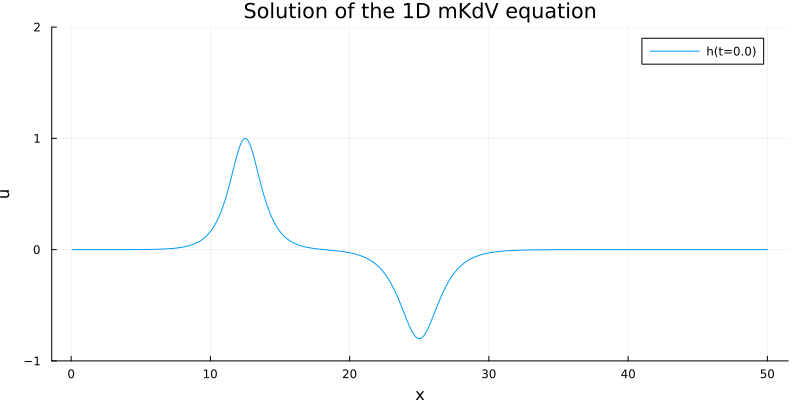

In [18]:
# create a movie of the solution
@time begin
    # create a movie of the solution
    anim = @animate for i in 1:length(sol.t)
        p1 = plot(x, sol[i], label="h(t=$(round(sol.t[i],digits=2)))", xlabel="x", ylabel="u", ylim=(-1, 2))
        plot(p1, size=(800,400), title="Solution of the 1D mKdV equation")
    end
    gif(anim, "mkdv1d_periodic.gif", fps=30)
end


In [19]:
# save the solution to a JLD2 file
dt_out=0.1 # time-step for output
times=collect(0.0:dt_out:t_end) # output times
solution=[]
for t in times
    push!(solution, sol(t))
end
# save the solution to a JLD2 file
save("mkdv1d_periodic.jld2", 
    "solution", solution,
    "times", times,
    "params", (Δx=Δx, amplitudes=a, positions=x0),
    "grid", x,
    "dt_out", dt_out,
    "description", "Solution of the 1D Modified Korteweg-De Vries equation with periodic boundary conditions, using two solitons as initial condition.")


In [ ]:
# load the solution from the JLD2 file for testing
ff=load("mkdv1d_periodic.jld2")

@show ff["solution"][1][1:25:end] # show some values of the initial velocity field